# **Ensemble Learning Experiment**

Having experimented with different CNN and RNN architectures, we experimented with creating an ensemble model
Our ensemble model should combine a CNN and RNN, combining the spectrogram and MFCC inputs and training these networks in parallel. Conceptually, this would equate to combining different audio data to more accurately represent each audio file

## Environment Setup

just like before, we verify that the data is as expected

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
file_name = "/content/gdrive/MyDrive/fold_pointers_v2"
file_object = open(file_name,'rb')
fold_pointers = pickle.load(file_object)

In [ ]:
file_name = "/content/gdrive/MyDrive/labels_v2"
file_object = open(file_name,'rb')
labels = pickle.load(file_object)

In [ ]:
labels = np.array(labels)

In [ ]:
file_name = "/content/gdrive/MyDrive/spec_data_v2"
file_object = open(file_name,'rb')
spec_data = pickle.load(file_object)

In [ ]:
spec_data = np.expand_dims(spec_data, axis = 3)

In [ ]:
spec_data_channels = np.repeat(spec_data, 3, axis = 3)

In [ ]:
spec_data_channels.shape

(8725, 128, 173, 3)

In [ ]:
file_name = "/content/gdrive/MyDrive/mfcc_data_v2"
file_object = open(file_name,'rb')
mfcc_data = pickle.load(file_object)

In [ ]:
mfcc_data.shape

(8725, 40, 321)

In [5]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

## **RNN + CNN Selection and Training**

We combine the VGG16 network and a selected RNN network. Instead of having at the top of each model one or more fully connected layers, we instead combine the outputs of both networks by concatenating them and use this combined input as input to a series of fully connected layers, also returning a probability vector with softmax activation

In [ ]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, MaxPool2D
from keras.optimizers import Adam
from sklearn import metrics
from keras import layers


inputCNN = Input(shape = (128,173,3))


#block 1
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(inputCNN)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# 2nd Conv Block

#block 2
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# 3rd Conv block

#block 3
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)# 4th Conv block

#block 4
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

#block 5
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)



inputRNN = layers.Input(shape=(40, 321))
lc1=layers.LSTM(40,dropout=0.2,return_sequences=True)(inputRNN)
lc2=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc1)
lc3=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc2)
lc4=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc3)
lc5=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc4)
lc6=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc5)
lc7=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc6)
lc8=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc7)
lc9=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc8)
lc10=layers.LSTM(40,dropout=0.2,return_sequences=True)(lc9)
add1=layers.Add()([lc1,lc10])
add2=layers.Add()([lc2,lc10])
add3=layers.Add()([lc3,lc10])
add4=layers.Add()([lc4,lc10])
add5=layers.Add()([lc5,lc10])
add6=layers.Add()([lc6,lc10])
add7=layers.Add()([lc7,lc10])
add8=layers.Add()([lc8,lc10])
add9=layers.Add()([lc9,lc10])
add_all = layers.Add()([add1,add2,add3,add4,add5,add6,add7,add8,add9,lc10])
sft=layers.Softmax()(add_all)
m1=layers.Multiply()([lc1,sft])
m2=layers.Multiply()([lc2,sft])
m3=layers.Multiply()([lc3,sft])
m4=layers.Multiply()([lc4,sft])
m5=layers.Multiply()([lc5,sft])
m6=layers.Multiply()([lc6,sft])
m7=layers.Multiply()([lc7,sft])
m8=layers.Multiply()([lc8,sft])
m9=layers.Multiply()([lc9,sft])
m10=layers.Multiply()([lc10,sft])
conc=layers.Concatenate()([m1,m2,m3,m4,m5,m6,m7,m8,m9,m10])
flt=layers.Flatten('channels_first')(conc)
dense=layers.Dense(10,kernel_regularizer='l2')(flt)

#combined output
combination = layers.Concatenate()([x, dense])
dense_1 = layers.Dense(10, kernel_regularizer = 'l2')(combination)
sft = layers.Softmax()(dense_1)
tan_h = layers.Activation(keras.activations.tanh)(sft)

ensemble = keras.Model(inputs = [inputCNN, inputRNN], outputs = tan_h)
ensemble.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 173, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 173, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 173, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 87, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

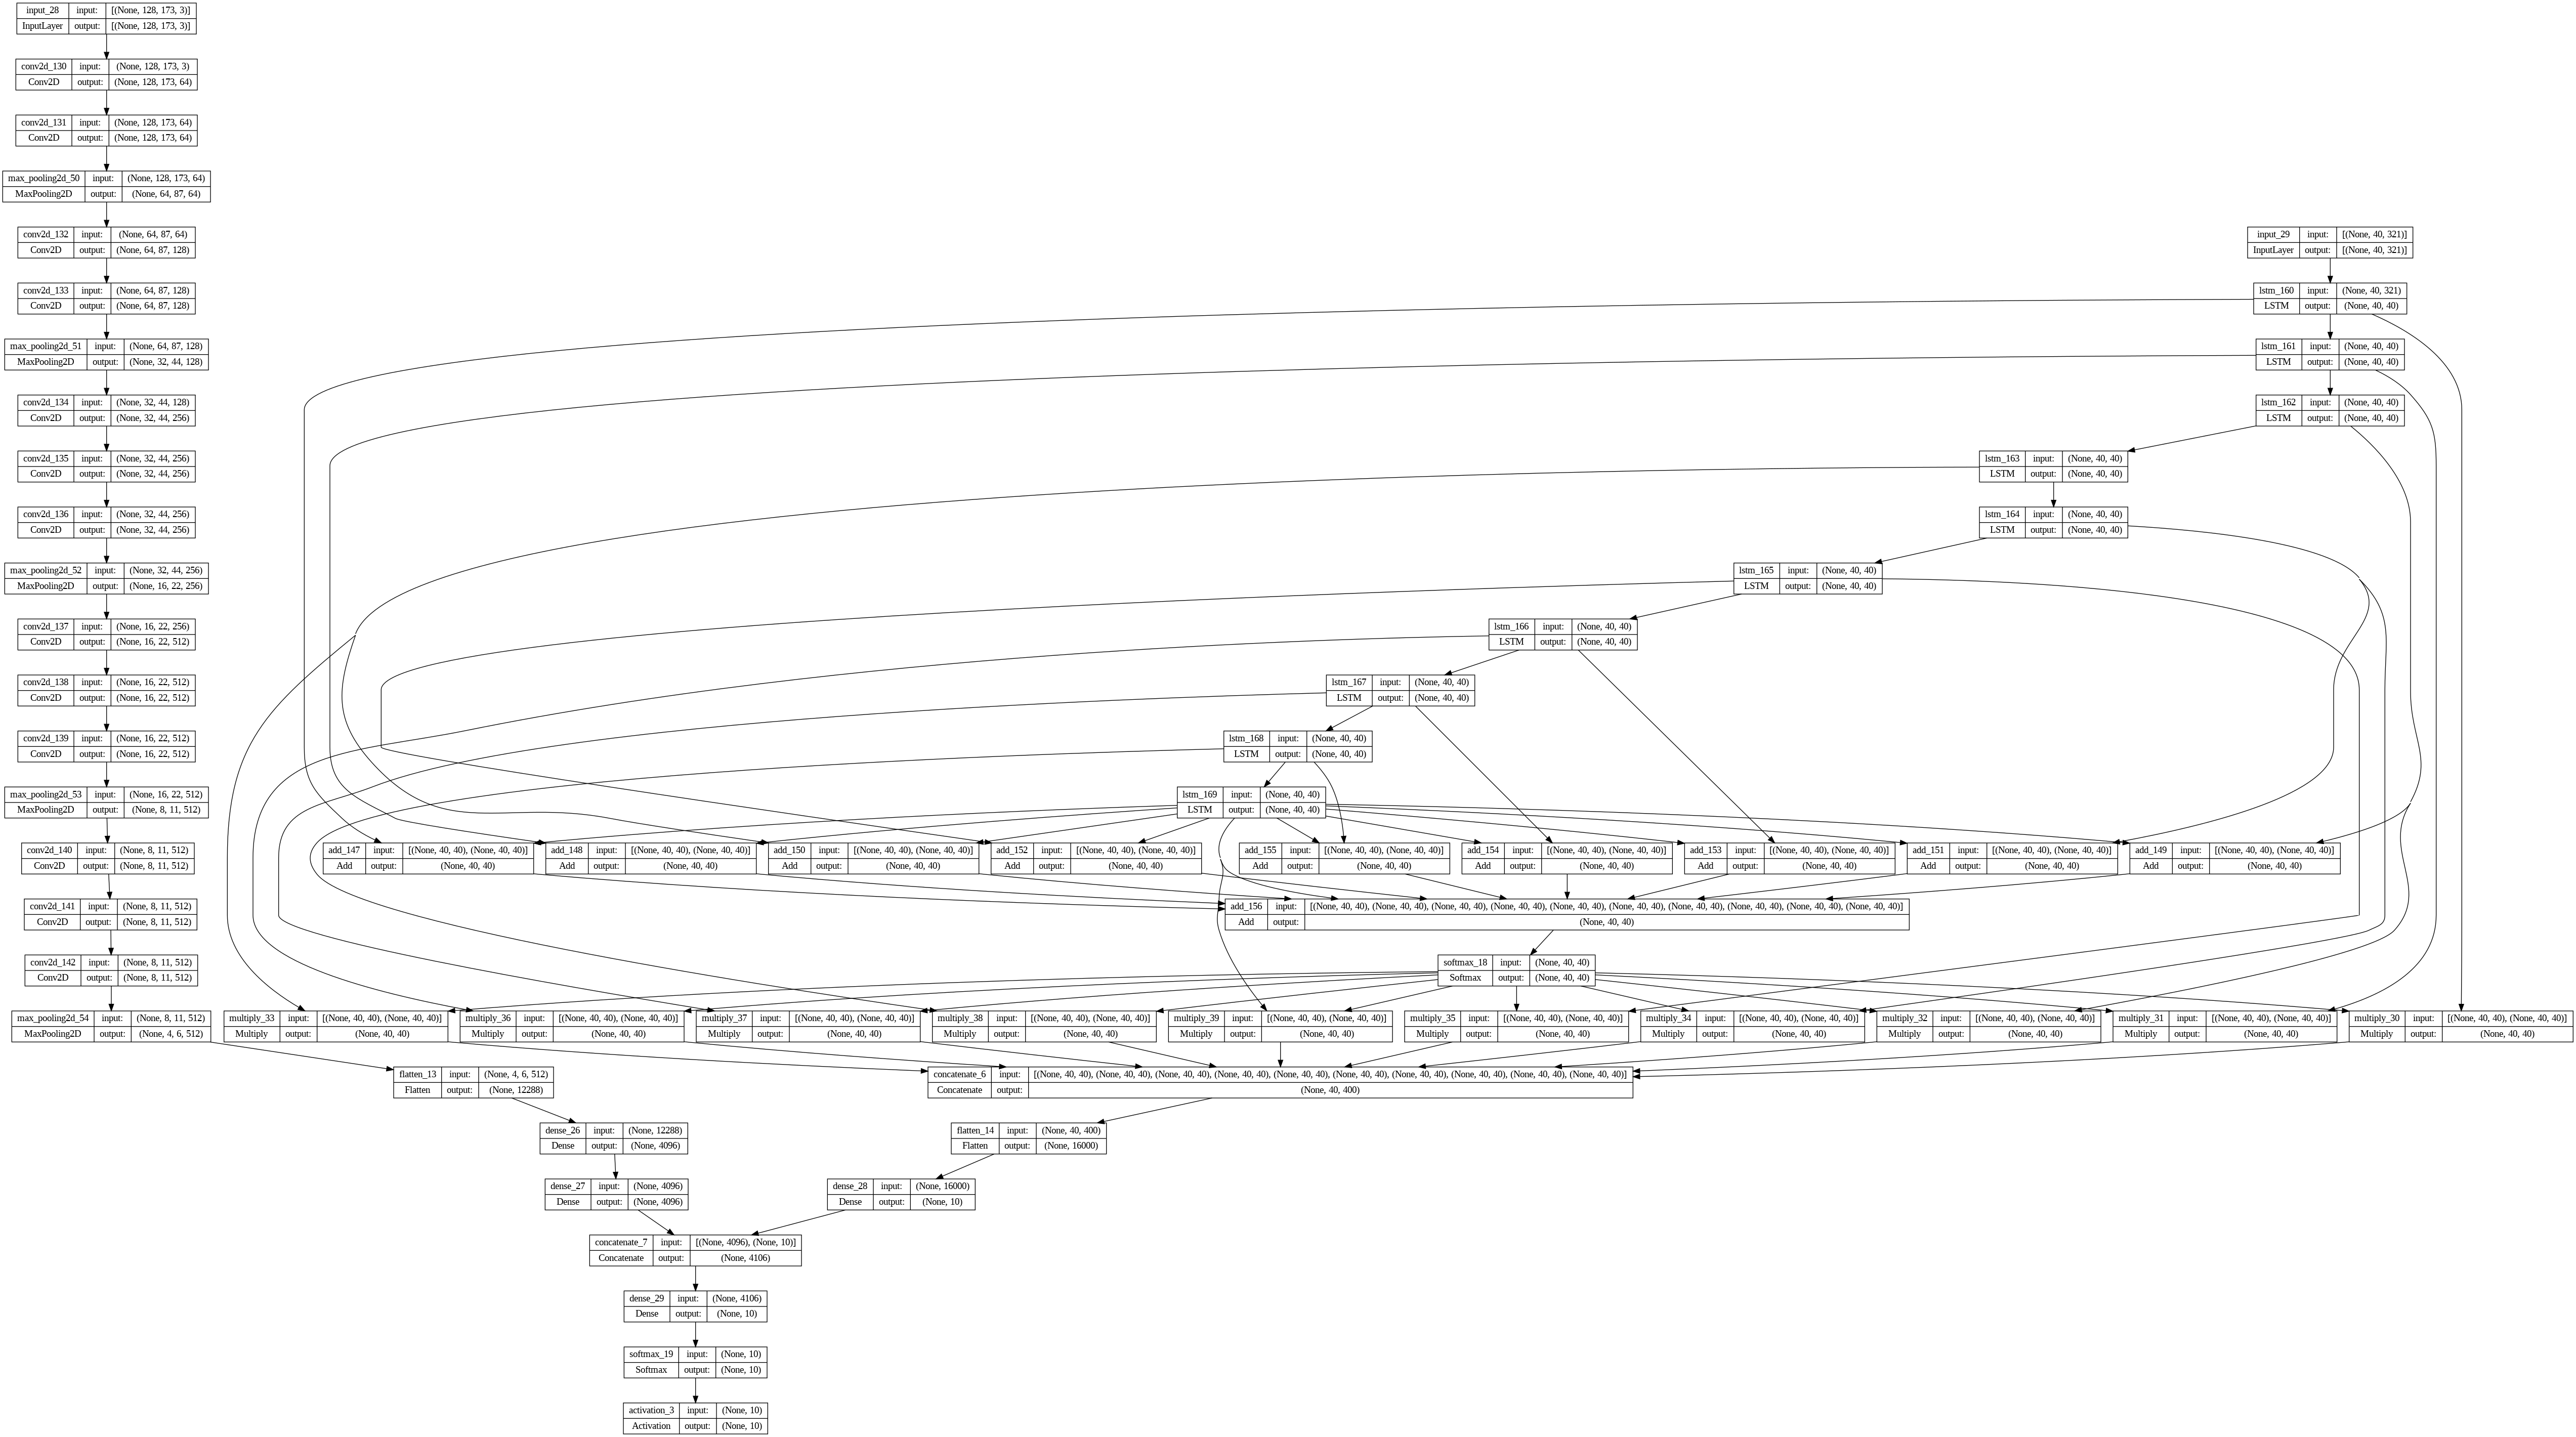

In [ ]:
tf.keras.utils.plot_model(ensemble, show_shapes=True)

the ennsemble model is compiled with the same hyperparameters used in the CNN approach and trained just as before using 10-fold cross validation

In [ ]:
ensemble.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy', optimizer = 'adam')

In [ ]:
ensemble.save_weights('ensemble_default.h5')

In [ ]:
for i in range(len(fold_pointers)-1):
    ensemble.load_weights('ensemble_default.h5')
    fold_start = fold_pointers[i]
    fold_end = fold_pointers[i+1]

    print('training with fold '+str(i+1)+' as validation')

    train_features_data_spec = np.concatenate((spec_data_channels[:fold_start-1], spec_data_channels[fold_end:]))
    train_features_data_mfcc = np.concatenate((mfcc_data[:fold_start-1], mfcc_data[fold_end:]))

    train_label_data = np.concatenate((labels[:fold_start-1], labels[fold_end:]))

    validation_features_data_mfcc = mfcc_data[fold_start-1:fold_end]
    validation_features_data_spec = spec_data_channels[fold_start-1:fold_end]

    validation_label_data = labels[fold_start-1:fold_end]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    ensemble.fit([train_features_data_spec, train_features_data_mfcc], train_label_data, batch_size=128, epochs=30, validation_data = ([validation_features_data_spec, validation_features_data_mfcc], validation_label_data), callbacks = [callback], verbose = 1)
    history = ensemble.history
    with open('/content/gdrive/MyDrive/'+'ensemble_history'+'_fold'+str(i+1), 'wb') as file:
      model_history= History_trained_model(history.history, history.epoch, history.params)
      pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)
    ensemble.save_weights('ensemble_'+'fold'+str(i+1))

training with fold 1 as validation
Epoch 1/30
62/62 [==============================] - 31s 197ms/step - loss: 1.9346 - accuracy: 0.2835 - val_loss: 2.0627 - val_accuracy: 0.2471
Epoch 2/30
62/62 [==============================] - 8s 122ms/step - loss: 1.5895 - accuracy: 0.4178 - val_loss: 1.7807 - val_accuracy: 0.3696
Epoch 3/30
62/62 [==============================] - 8s 122ms/step - loss: 1.2972 - accuracy: 0.5387 - val_loss: 1.4444 - val_accuracy: 0.4577
Epoch 4/30
62/62 [==============================] - 8s 122ms/step - loss: 1.0838 - accuracy: 0.6253 - val_loss: 1.4329 - val_accuracy: 0.5378
Epoch 5/30
62/62 [==============================] - 8s 122ms/step - loss: 0.9235 - accuracy: 0.6943 - val_loss: 1.3152 - val_accuracy: 0.5641
Epoch 6/30
62/62 [==============================] - 8s 122ms/step - loss: 0.7985 - accuracy: 0.7365 - val_loss: 1.1928 - val_accuracy: 0.5686
Epoch 7/30
62/62 [==============================] - 8s 122ms/step - loss: 0.6748 - accuracy: 0.7892 - val_loss: 

**we notice the same overfitting behavior in the ensemble model and the overall performance was not much greater than what we previously saw using simples models. Further testing of this model and possible modifications were again cut short because of constraints regarding time and computational capacity**

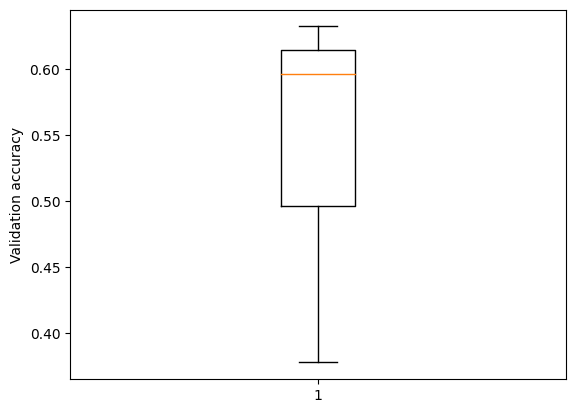

Average accuracy: 0.55
Max accuracy: 0.63
Min accuracy: 0.38


In [6]:
accuracies = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'ensemble_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  accuracies.append(history.history['val_accuracy'][len(history.history['val_accuracy'])-1])

fig = plt.figure()
plt.ylabel('Validation accuracy')
plt.boxplot(accuracies)
plt.show()
print(f"Average accuracy: {np.mean(accuracies):.2f}")
print(f"Max accuracy: {np.max(accuracies):.2f}")
print(f"Min accuracy: {np.min(accuracies):.2f}")

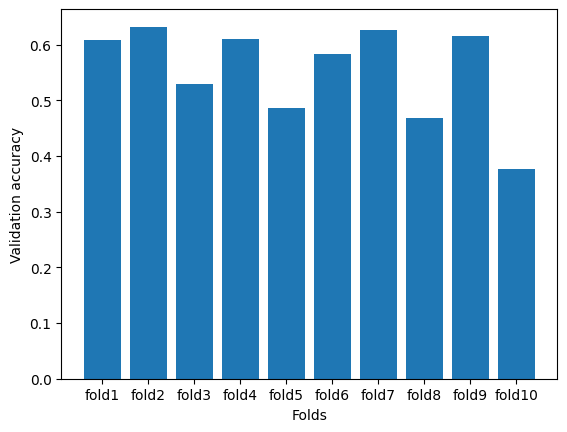

In [7]:
folds = []

for i in range(1, 11):
  with open('/content/gdrive/MyDrive/'+'ensemble_history'+'_fold' + str(i), 'rb') as file:
    history=pickle.load(file)
  folds.append('fold'+str(i))

fig = plt.figure()
plt.xlabel('Folds')
plt.ylabel('Validation accuracy')
plt.bar(folds, height = accuracies)
plt.show()

In [8]:
with open('/content/gdrive/MyDrive/'+'ensemble_history'+'_fold2', 'rb') as file:
    history=pickle.load(file)

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


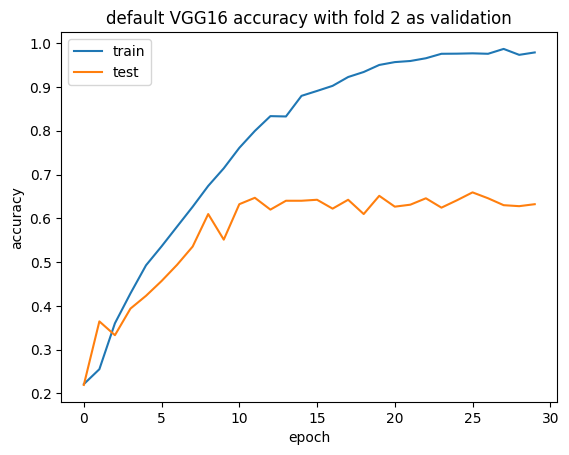

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('default VGG16 accuracy with fold 2 as validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

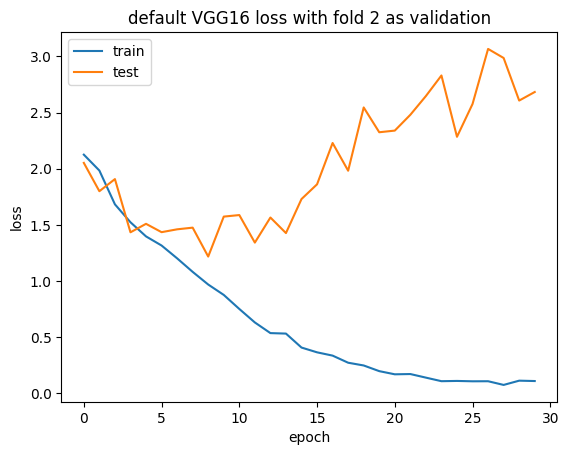

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('default VGG16 loss with fold 2 as validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()